# Download and extract data

In [5]:
!wget http://konect.cc/files/download.tsv.facebook-wosn-wall.tar.bz2
!tar -xf download.tsv.facebook-wosn-wall.tar.bz2
!rm download.tsv.facebook-wosn-wall.tar.bz2

--2021-02-09 14:11:45--  http://konect.cc/files/download.tsv.facebook-wosn-wall.tar.bz2
Resolving konect.cc (konect.cc)... 138.48.20.248
Connecting to konect.cc (konect.cc)|138.48.20.248|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6265543 (6.0M) [application/x-bzip2]
Saving to: 'download.tsv.facebook-wosn-wall.tar.bz2'

100%[======================================>] 6,265,543   34.3MB/s   in 0.2s   

2021-02-09 14:11:45 (34.3 MB/s) - 'download.tsv.facebook-wosn-wall.tar.bz2' saved [6265543/6265543]



# Setup

In [35]:
from importlib import reload
import os

import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker 
import networkx as nx
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.metrics
import seaborn as sns
from tqdm.auto import tqdm

import lp
reload(lp)

temp_path = '04/temp'
os.makedirs(temp_path, exist_ok=True)

cutoff = 2

# Get network

In [8]:
edgelist = lp.konect_to_pandas('04/out.facebook-wosn-wall', sep=' ')
edgelist.to_pickle(f'{temp_path}/edgelist.pkl')
edgelist

,u,v,datetime
0,1,1,2004-09-14 04:23:51
1,2,3,2004-10-14 03:43:26
2,4,4,2004-10-21 19:39:29
3,5,5,2004-10-22 06:06:44
4,2,3,2004-10-23 00:02:42
...,...,...,...
876988,1559,22224,2009-01-22 04:11:22
876989,20435,20435,2009-01-22 04:20:51
876990,31820,36225,2009-01-22 04:26:10
876991,13508,22745,2009-01-22 04:31:12


In [9]:
%%time
multigraph = nx.from_pandas_edgelist(
  edgelist, source='u', target='v', edge_attr=True, create_using=nx.MultiGraph)
nx.write_gpickle(multigraph, f'{temp_path}/multigraph.pkl')

CPU times: user 6.35 s, sys: 168 ms, total: 6.52 s
Wall time: 6.53 s


## Figure: Event distribution with maturing and probing intervals indicated

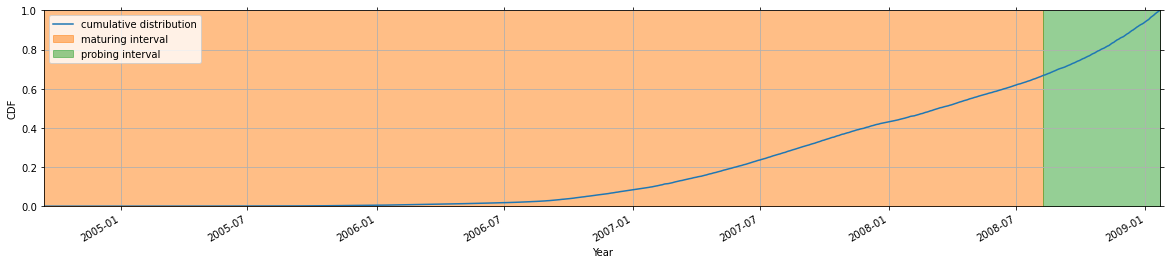

In [10]:
lp.plot_interval(joblib.load(f'{temp_path}/edgelist.pkl')['datetime'])

# Maturing and probing

In [11]:
%%time
edgelist_mature, edgelist_probe = lp.split_in_intervals(
  edgelist=joblib.load(f'{temp_path}/edgelist.pkl'))

index, y = lp.get_instances(
  edgelist_mature=edgelist_mature, edgelist_probe=edgelist_probe, 
  cutoff=cutoff, verbose=True)

Determine targets:   0%|          | 0/1763892 [00:00<?, ?it/s]

CPU times: user 14.8 s, sys: 365 ms, total: 15.2 s
Wall time: 15.1 s


In [12]:
%%time
edgelist_mature.to_pickle(f'{temp_path}/edgelist_mature.pkl')
np.save(f'{temp_path}/index', index)
np.save(f'{temp_path}/y', y)

CPU times: user 4.12 ms, sys: 19.5 ms, total: 23.6 ms
Wall time: 109 ms


## Metric: class imbalance

In [13]:
pd.Series(y).value_counts()

False    1756214
True        7678
dtype: int64

In [14]:
pd.Series(y).value_counts(normalize=True)

False    0.995647
True     0.004353
dtype: float64

# Network characteristics

In [15]:
for folder in ['stats', 'path_distribution']: 
  os.makedirs(f'{temp_path}/{folder}', exist_ok=True)

# Complete graph
path_distribution, stat = lp.report(
  joblib.load(f'{temp_path}/multigraph.pkl'))
joblib.dump(stat, f'{temp_path}/stats/complete.pkl')
joblib.dump(path_distribution, f'{temp_path}/path_distribution/complete.pkl')

# Graph of maturing interval
graph_mature = nx.from_pandas_edgelist(
  joblib.load(f'{temp_path}/edgelist_mature.pkl'), source='u', target='v', 
  edge_attr=True, create_using=nx.MultiGraph)

path_distribution, stat = lp.report(graph_mature)
joblib.dump(stat, f'{temp_path}/stats/mature.pkl')
joblib.dump(path_distribution, f'{temp_path}/path_distribution/mature.pkl')

['04/temp/path_distribution/mature.pkl']

## Table: Statistics

In [16]:
pd.DataFrame.from_dict(
  {file.split('.')[0]: joblib.load(f'{temp_path}/stats/{file}') 
   for file in os.listdir(f'{temp_path}/stats')}, orient='index')

,nodes,nodes (GC),edges,edges (GC),edges (simplegraph),"edges (simplegraph, GC)",average number of edges between connected node pairs,density,density (GC),density (simplegraph),"density (simplegraph, GC)",assortativity,assortativity (simplegraph),diameter,average path length,average clustering coefficient
complete,46952,43953,876993,872044,193494,191128,0.220633,0.000796,0.000903,0.000176,0.000198,0.461899,0.234820,15,5.626741,0.107964
mature,30011,26342,584662,578236,118637,115523,0.202916,0.001298,0.001667,0.000263,0.000333,0.448529,0.221575,15,5.372951,0.106121


## Figure: Path distributions

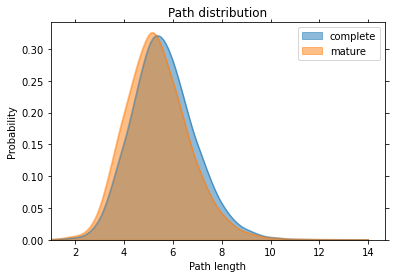

In [17]:
df = pd.DataFrame(
  {file.split('.')[0]: (
    pd.Series(joblib.load(f'{temp_path}/path_distribution/{file}')[:,1])
    .transform(lambda x: x/x.sum()))
   for file in os.listdir(f'{temp_path}/path_distribution')})
with plt.rc_context({'xtick.top': True, 'ytick.right': True}):
  (df
   .reindex(np.arange(0, df.index.max(), .1))
   .interpolate('akima', limit_area='inside')
   .dropna(how='all')
  ).plot(kind='area', xlim=(1), ylim=(0), stacked=False, alpha=.5, 
         title='Path distribution', xlabel='Path length', ylabel='Probability')

## Figure: Time strategies

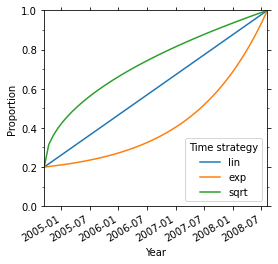

In [18]:
edgelist_mature, _ = lp.split_in_intervals(
  edgelist=joblib.load(f'{temp_path}/edgelist.pkl'))
lp.plot_time_strategies(edgelist_mature['datetime'])

## Figure: Time output distribution

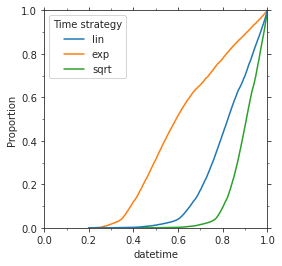

In [19]:
edgelist_mature, _ = lp.split_in_intervals(
  edgelist=joblib.load(f'{temp_path}/edgelist.pkl'))
sns.set_style('ticks')
data = pd.concat(
  {time_str: time_func(edgelist_mature['datetime']) 
   for time_str, time_func in lp.TIME_STRATEGIES.items()}, 
  names=['Time strategy', 'index']
).reset_index('Time strategy').reset_index(drop=True)
with plt.rc_context({'xtick.top': True, 'ytick.right': True, 
                     'figure.figsize': (4,4)}):
  ax = sns.ecdfplot(data=data, x='datetime', hue='Time strategy')
  ax.set_xlim((0,1))
  ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.1))
  ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.1))

# Sample

In [20]:
%%time
index_sampled, index_y = lp.balanced_sample(
  index=np.load(f'{temp_path}/index.npy'), 
  y=np.load(f'{temp_path}/y.npy'), 
  size=10000)

np.save(f'{temp_path}/index_sampled', index_sampled)
np.save(f'{temp_path}/y_sampled', index_y)

CPU times: user 37.8 ms, sys: 11.1 ms, total: 48.9 ms
Wall time: 50.2 ms


# Learn

In [24]:
os.makedirs(f'{temp_path}/features', exist_ok=True)

## Adamic Adar

### Time agnostic

In [28]:
%%time
adamic_adar_time_agnostic = lp.adamic_adar_time_agnostic(
  edgelist=joblib.load(f'{temp_path}/edgelist_mature.pkl'),
  samples=np.load(f'{temp_path}/index_sampled.npy'))
joblib.dump([adamic_adar_time_agnostic], 
            f'{temp_path}/features/adamic-adar-time-agnostic.pkl')

CPU times: user 1.43 s, sys: 11.8 ms, total: 1.44 s
Wall time: 1.49 s


['04/temp/features/adamic-adar-time-agnostic.pkl']

### Time aware

In [26]:
adamic_adar_time_aware = lp.adamic_adar_time_aware(
  edgelist=joblib.load(f'{temp_path}/edgelist_mature.pkl'),
  samples=np.load(f'{temp_path}/index_sampled.npy'),
  verbose=True
)

joblib.dump(adamic_adar_time_aware, 
            f'{temp_path}/features/adamic-adar-time-aware.pkl')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

['04/temp/features/adamic-adar-time-aware.pkl']

## Number of shortest path
Mind that only distance-2 node pairs are used at the moment.

In [27]:
# Slow method, but providing also shortest paths at greater distance:
# [len(list(nx.all_shortest_paths(multigraph_mature, *sample))) for sample in tqdm(np.load('temp/samples.npy'))]

def single_source_number_paths_length_2(graph: nx.Graph, source):
  result = dict()
  for nb in graph[source]:
    for nnb in graph[nb]:
      result[nnb] = result.get(nnb, 0) + 1
  return result

multigraph_mature = nx.read_gpickle(f'{temp_path}/multigraph-mature.pkl')

paths__of_length_2_from_node_u = {
  node: single_source_number_paths_length_2(multigraph_mature, node) 
  for node in np.load(f'{temp_path}/samples.npy')[:,0]}

feature = [{
  'score': np.array(
    [result[u][v] for u, v in tqdm(np.load(f'{temp_path}/samples.npy'))]),
  'Feature': 'Number of shortest paths',
  'Aggregation strategy': np.nan,
  'Time strategy': np.nan}]

joblib.dump(feature, 
            f'{temp_path}/features/number-shortest-paths-time-unaware.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '04/temp/multigraph-mature.pkl'

# Results

In [36]:
path = f'{temp_path}/features/'
experiments = list()
for file in os.listdir(path): 
  if file.endswith('.pkl'):
    experiments.extend(joblib.load(path + file))

## Figure: Score distribution

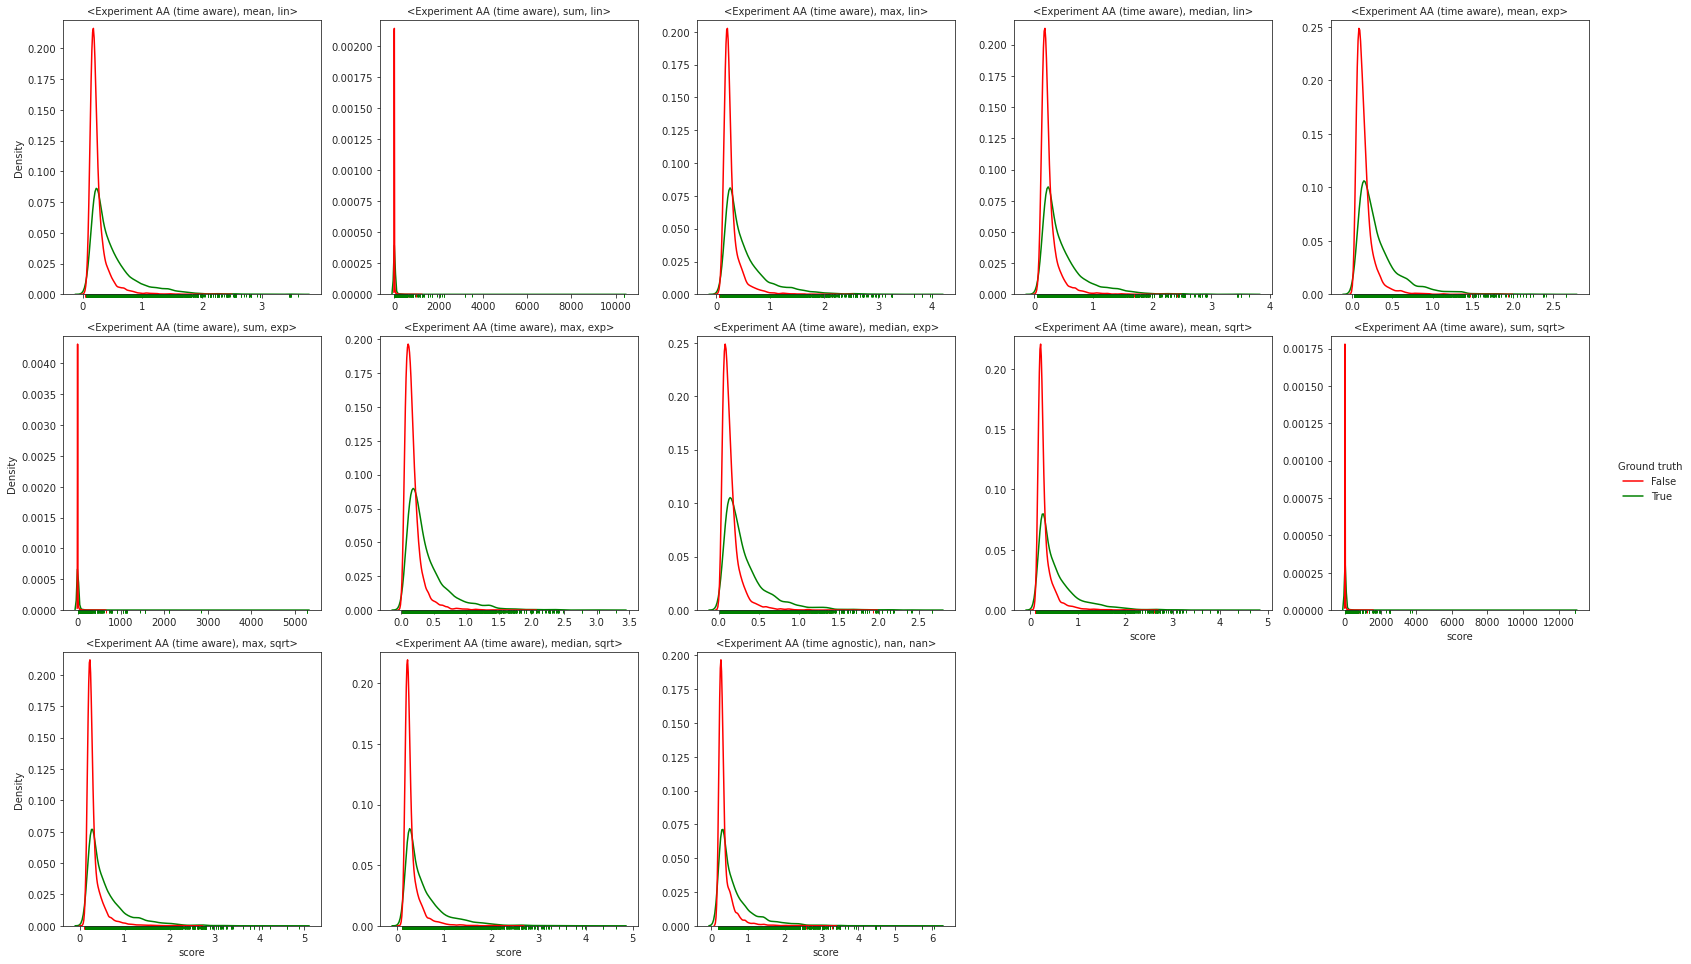

In [32]:
y_sampled = np.load(f'{temp_path}/y_sampled.npy')
g = sns.displot(
  data=pd.DataFrame.from_dict(
    [{'Feature': experiment.__repr__(), 'score': score, 'Ground truth': y}
     for experiment in experiments
     for score, y in zip(experiment.scores, y_sampled)]),
  x='score', hue='Ground truth', col='Feature', kind='kde', 
  palette=['red', 'green'], height=4.5, rug=True, col_wrap=5,
  rug_kws=dict(height=-.01, clip_on=False), 
  facet_kws=dict(sharex=False, sharey=False, despine=False))
g.set_titles(col_template="{col_name}")

## Figure: ROC plot

In [33]:
data = pd.DataFrame([
  dict(FPR=fpr, TPR=tpr, **experiment)
  for experiment in experiments
  for fpr, tpr, _ in zip(*roc_curve(samples_y, experiment['score']))]
).fillna({'Aggregation strategy': '', 'Time strategy': 'not used'})

NameError: name 'roc_curve' is not defined

In [ ]:
data

In [ ]:
g = sns.relplot(
  data=data, x='FPR', y='TPR', hue='Time strategy', 
  style='Aggregation strategy', col='Feature', col_wrap=5, aspect=1, 
  kind='line')
g.map(plt.axline, xy1=(0,0), xy2=(1,1), c='black')
g.set(xlim=(0,1), ylim=(0,1))

## Table: AUC

In [37]:
y_sampled = np.load(f'{temp_path}/y_sampled.npy')
pd.Series(
  {tuple(experiment.get_parameters().values()): 
   sklearn.metrics.roc_auc_score(y_sampled, experiment.scores) 
   for experiment in experiments}
).reset_index().groupby(['level_0']).mean()

,0
level_0,
AA (time agnostic),0.728376
AA (time aware),0.738677
